# Tutorial 2. Advanced capabilities of the MeasurementControl

In this tutorial, we will explore the more advanced features of quantify. By the end of this tutorial, we will have covered:

- Using hardware to drive experiments
- Software averaging
- Safely interrupting a running experiment

In [1]:
import time
import random

import numpy as np
import xarray as xr
import scipy
from qcodes import ManualParameter, Parameter
%matplotlib inline
from quantify.measurement.control import MeasurementControl
import quantify.visualization.pyqt_plotmon as pqm

In [2]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon_MC')
MC.instr_plotmon(plotmon.name)

## A 1D hard(ware) controlled loop: Resonator Spectroscopy
### Defining a simple model

In this example, we want to find the resonance of some device. We expect to find it's resonance somewhere in the low 6GHz range, but manufacturing imperfections makes it impossible to know exactly without inspection.

We first create a `Settable` with a `QCodes.Parameter` to represent our frequency sweep range, followed by a custom `Gettable` to mock the resonating material. The Resonator will return a Lorentzian shape centred on the resonant frequency. Our `Gettable` will read the setpoints from `freq`, in this case a 1D array.

Note that the Resonator `Gettable` has a new field `soft` set to `False`. This property informs the MeasurementControl does not drive the Resonator, but instead the Resonator manages its own data acquisition.

In [6]:
freq = ManualParameter(name='frequency', unit='Hz', label='Frequency')


def lorenz(amplitude, fwhm, x, x_0):
    return (amplitude * ((fwhm / 2.) ** 2) / ((x - x_0) ** 2 + (fwhm / 2.) ** 2))


class Resonator:
    def __init__(self):
        self.name = 'resonator'
        self.unit = 'V'
        self.label = 'Amplitude'
        self.soft = False
        self.test_resonance = 6.0001048e9 # in Hz
        self.test_width = 300 # FWHM in Hz

    def get(self):
        return 1-np.array(list(map(lambda x: lorenz(1, self.test_width, x, self.test_resonance), freq())))


### Running the experiment
Just like our `soft` 1D loop, our complete experiment is expressed in just four lines of code.

The main difference is defining the `soft` property of our `Gettable` to False. The `MeasurementControl` will detect these settings and run in the appropriate`hard` mode.

In [7]:
MC.settables(freq)
MC.setpoints(np.arange(6.0001e9, 6.00011e9))
MC.gettables(Resonator())
dset = MC.run()

 100% completed 	elapsed time: 0.8s 	time left: 0.0s


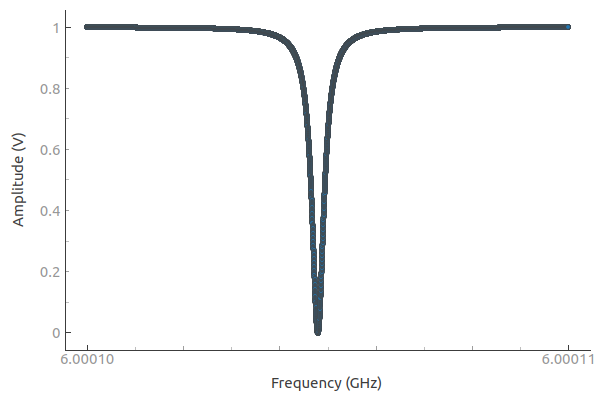

In [8]:
plotmon.main_QtPlot

As expected, we find a Lorentzian spike in the readout at the resonant frequency, finding the peak of which is trivial.

## Software Averaging: T1 Experiment
In many cases it is desirable to run an experiment many times and average the result, such as when filtering noise on instruments or measuring probability. For this purpose, the MeasurementControl provides the `soft_avg` parameter. If set to x, the experiment will run x times whilst performing a running average over each setpoint.

In this example, we want to find the relaxation time (or T1) of a Qubit. As before, we define a `Settable` and `Gettable`, representing the varying timescales we will probe through and a mock Qubit emulated in software. The mock Qubit returns the expected decay sweep but with a small amount of noise (simulating the variable qubit characteristics). We also set the qubit's T1 to 60ms - obviously in a real experiment we would be trying to discern this, but for this tutorial we set it to a known value to verify our fit later on.

In [9]:
def decay(t, tau):
    return np.exp(-t/tau)

time_par = ManualParameter(name='time', unit='s', label='Measurement Time')

class MockQubit:
    def __init__(self):
        self.name = 'qubit'
        self.unit = '%'
        self.label = 'High V'
        self.delay = 0.05 # sleep time in secs
        self.soft = False
        self.test_relaxation_time = 60e-6

    def get(self):
        time.sleep(self.delay)
        return np.array(list(map(lambda x: decay(x, self.test_relaxation_time) + random.uniform(-0.1, 0.1), time_par())))


We will then sweep through 0 to 300ms, getting our data from the mock Qubit:

 100% completed 	elapsed time: 0.9s 	time left: 0.0s


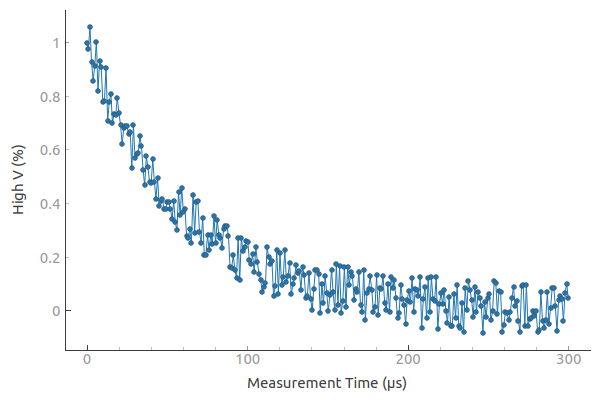

In [10]:
MC.settables(time_par)
MC.setpoints(np.linspace(0.0, 300.0e-6, 300))
MC.gettables(MockQubit())
MC.run('noisy')
plotmon.main_QtPlot

Alas, the noise in the signal has made this result unusable! Let's set the `soft_avg` parameter of the MeasurementControl to 5000. As above, this will run the experiment 5000 times, averaging the results and hopefully filtering out the noise.

 100% completed 	elapsed time: 4.5s 	time left: 0.0s


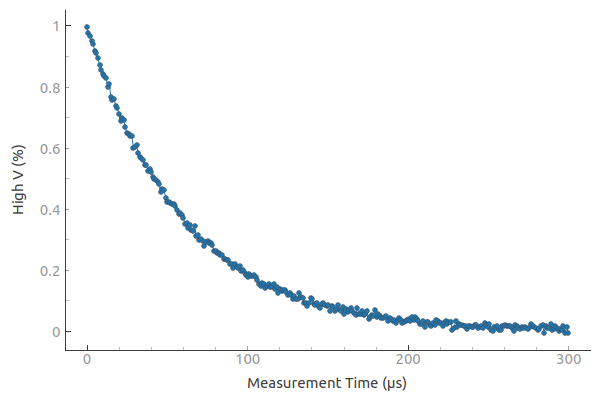

In [11]:
MC.soft_avg(50)
dset = MC.run('averaged')
plotmon.main_QtPlot

Success! We now have a smooth decay curve based on the characteristics of our qubit. All that remains is to run a fit against the expected values and we can solve for T1.

{'tau': 6.0068601198178244e-05}

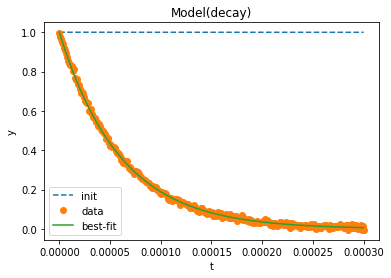

In [12]:
from lmfit import Model

model = Model(decay, independent_vars=['t'])
fit_res = model.fit(dset['y0'].values, t=dset['x0'].values, tau=1)

fit_res.plot_fit(show_init=True)
fit_res.values